In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *

In [3]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [4]:
PATH = "../../data/dogscats/"

In [5]:
sz = 224

In [6]:
!ls {PATH}

models	sample	test1  tmp  train  valid


In [7]:
!ls {PATH}valid

cats  dogs


In [8]:
files = !ls {PATH}valid/cats | head 
files

['cat.10016.jpg',
 'cat.1001.jpg',
 'cat.10026.jpg',
 'cat.10048.jpg',
 'cat.10050.jpg',
 'cat.10064.jpg',
 'cat.10071.jpg',
 'cat.10091.jpg',
 'cat.10103.jpg',
 'cat.10104.jpg']

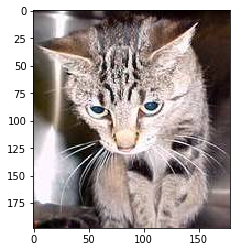

In [9]:
img = plt.imread(f'{PATH}valid/cats/{files[0]}')
plt.imshow(img)

In [10]:
img.shape

(198, 179, 3)

In [11]:
img[:4,:4]

array([[[ 29,  20,  23],
        [ 31,  22,  25],
        [ 34,  25,  28],
        [ 37,  28,  31]],

       [[ 60,  51,  54],
        [ 58,  49,  52],
        [ 56,  47,  50],
        [ 55,  46,  49]],

       [[ 93,  84,  87],
        [ 89,  80,  83],
        [ 85,  76,  79],
        [ 81,  72,  75]],

       [[104,  95,  98],
        [103,  94,  97],
        [102,  93,  96],
        [102,  93,  96]]], dtype=uint8)

In [12]:
arch = resnet34
data = ImageClassifierData.from_paths(PATH, tfms = tfms_from_model(arch, sz))

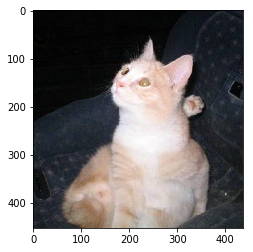

In [47]:
img = plt.imread(PATH + data.trn_ds.fnames[0])
plt.imshow(img)

In [43]:
x, y = next(iter(data.trn_dl))

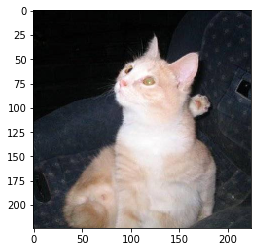

In [48]:
plt.imshow(data.trn_ds.denorm(data.trn_ds[0][0])[0])

In [41]:
imagenet_stats[0,None]

array([[ 0.485,  0.456,  0.406]])

In [33]:
imagenet_stats = np.array([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])

In [13]:
learn = ConvLearner.pretrained(arch, data, precompute = True)

In [14]:
learn.fit(0.01, 3)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

[ 0.       0.04495  0.02981  0.98682]                         
[ 1.       0.0366   0.02766  0.98877]                         
[ 2.       0.03258  0.0272   0.99023]                         



In [15]:
data.val_y, data.classes

(array([0, 0, 0, ..., 1, 1, 1]), ['cats', 'dogs'])

In [16]:
data.__dict__.keys()

dict_keys(['path', 'bs', 'num_workers', 'classes', 'trn_dl', 'val_dl', 'fix_dl', 'aug_dl', 'test_dl', 'test_aug_dl'])

In [17]:
data.val_ds.__dict__.keys()

dict_keys(['y', 'path', 'fnames', 'transform', 'n', 'c', 'sz'])

In [18]:
log_preds = learn.predict()
log_preds.shape

(2000, 2)

In [19]:
log_preds[:10]

array([[ -0.00003, -10.30078],
       [ -0.00984,  -4.6263 ],
       [ -0.00121,  -6.72116],
       [ -0.00028,  -8.17117],
       [ -0.00015,  -8.80428],
       [ -0.00032,  -8.048  ],
       [ -0.00007,  -9.56617],
       [ -0.00002, -11.05369],
       [ -0.00892,  -4.72341],
       [ -0.00037,  -7.88949]], dtype=float32)

In [20]:
preds = np.argmax(log_preds, axis = 1)

In [21]:
preds[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [22]:
prob = np.exp(log_preds[:,1]) # prob[dog]
probs = np.exp(log_preds[:,1])

In [23]:
prob[:10]

array([ 0.00003,  0.00979,  0.00121,  0.00028,  0.00015,  0.00032,  0.00007,  0.00002,  0.00888,  0.00037], dtype=float32)

In [24]:
# randomly pick images classified correctly 
idx_correct = (preds == data.val_y)

In [25]:
idx_correct_rand = np.random.choice(np.where(idx_correct)[0], 4, replace = False)

In [26]:
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

In [27]:
imgs = [load_img_id(data.val_ds, idx) for idx in idx_correct_rand]
titles = [prob[idx] for idx in idx_correct_rand]

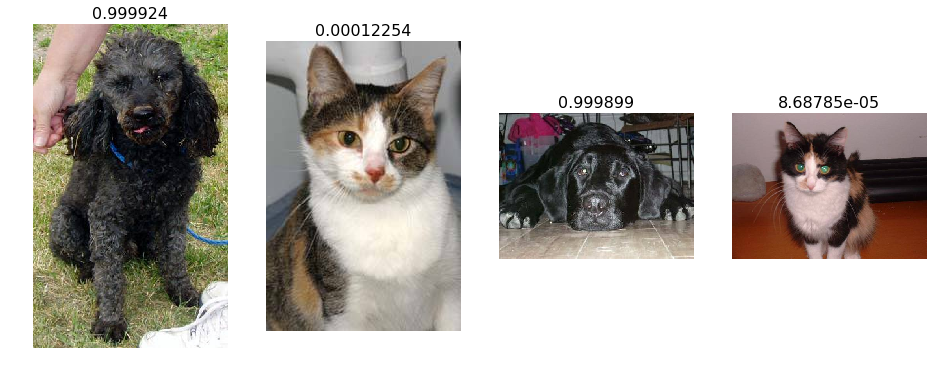

In [28]:
f = plt.figure(figsize = (16, 8))
for i in range(len(imgs)):
    sp = f.add_subplot(1, 4, i + 1)
    sp.axis("off")
    sp.set_title(titles[i], fontsize = 16)
    plt.imshow(imgs[i])

In [29]:
idx_wrong = np.where((preds != data.val_y))[0]

In [30]:
idx_wrong_rand = np.random.choice(idx_wrong, 4, replace = False)

In [31]:
imgs = [load_img_id(data.val_ds, idx) for idx in idx_wrong_rand]
titles = [prob[idx] for idx in idx_wrong_rand]

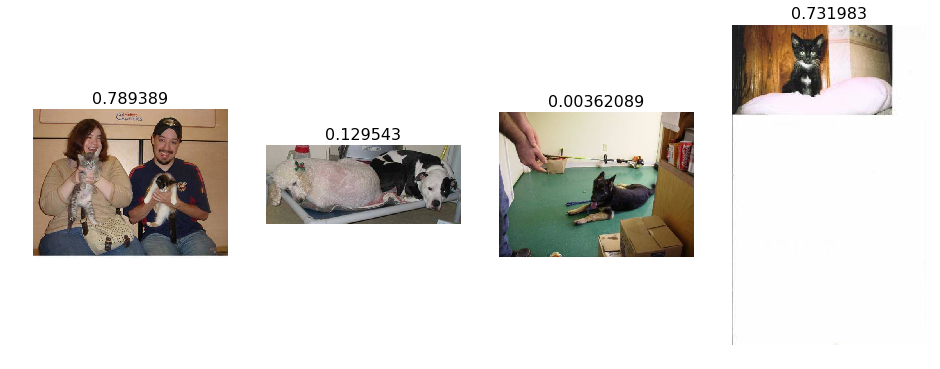

In [32]:
f = plt.figure(figsize = (16, 8))
for i in range(len(imgs)):
    sp = f.add_subplot(1, 4, i + 1)
    sp.axis("off")
    sp.set_title(titles[i], fontsize = 16)
    plt.imshow(imgs[i])

In [33]:
def getidx(preds, act, prob, predval, actval, mult):
    idx_correct = np.where(np.logical_and((preds == predval), (act == actval)))[0]
    idx_most_correct = idx_correct[np.argsort(mult*prob[idx_correct])[:4]]
    return(idx_most_correct)

In [34]:
def plots_with_titles(df, idx_most_correct, prob):
    imgs = [load_img_id(df, idx) for idx in idx_most_correct]
    titles = [prob[idx] for idx in idx_most_correct]

    f = plt.figure(figsize = (16, 8))
    for i in range(len(imgs)):
        sp = f.add_subplot(1, 4, i + 1)
        sp.axis("off")
        sp.set_title(titles[i], fontsize = 16)
        plt.imshow(imgs[i])

In [35]:
idx_most_correct = getidx(preds, data.val_y, prob, 1, 1, -1) # most correct dogs

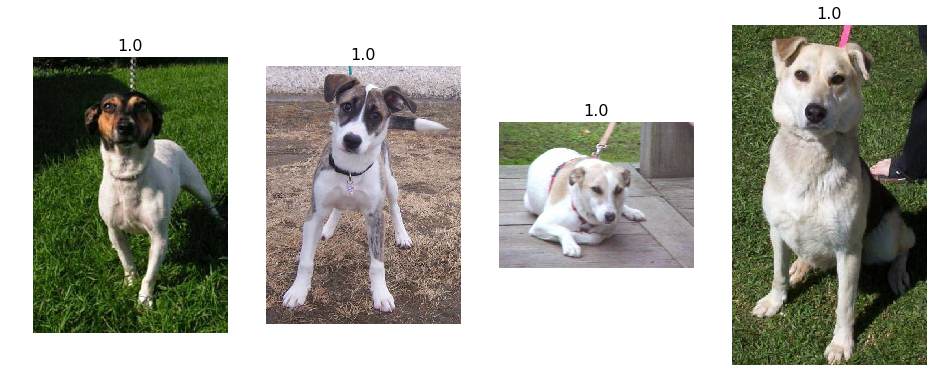

In [36]:
plots_with_titles(data.val_ds, idx_most_correct, prob)

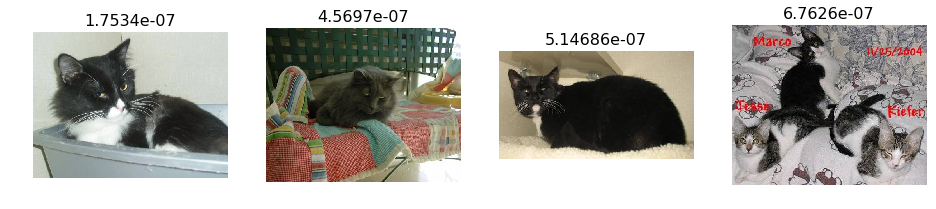

In [37]:
idx_most_correct = getidx(preds, data.val_y, prob, 0, 0, 1) # most correct cats
plots_with_titles(data.val_ds, idx_most_correct, prob)

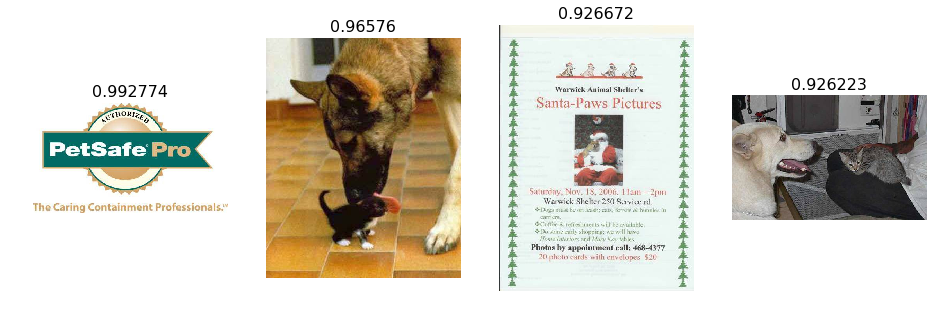

In [38]:
idx_most_wrong = getidx(preds, data.val_y, prob, 1, 0, -1) # most wrong dogs
plots_with_titles(data.val_ds, idx_most_wrong, prob)

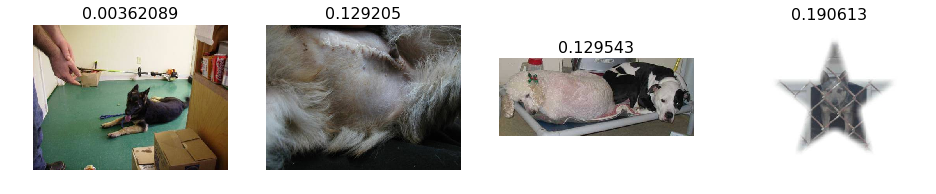

In [39]:
idx_most_wrong = getidx(preds, data.val_y, prob, 0, 1, 1) # most wrong cats
plots_with_titles(data.val_ds, idx_most_wrong, prob)

In [40]:
idx_most_uncertain = np.argsort(np.abs(prob - 0.5))[:4]

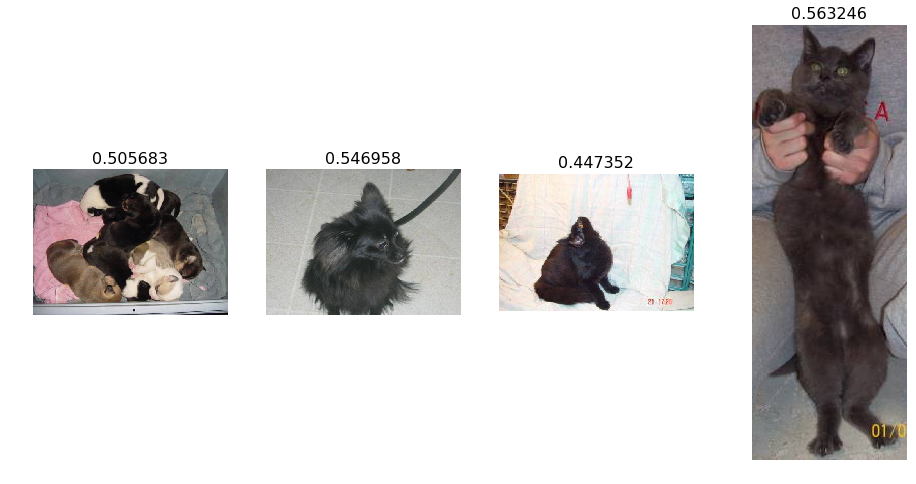

In [41]:
plots_with_titles(data.val_ds, idx_most_uncertain, prob)

In [42]:
learn = ConvLearner.pretrained(arch, data, precompute = True)

In [43]:
lrf = learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 79%|███████▉  | 286/360 [00:07<00:01, 38.70it/s, loss=0.42] 


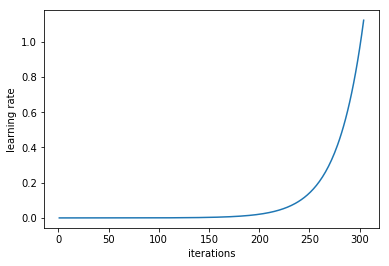

In [45]:
learn.sched.plot_lr()

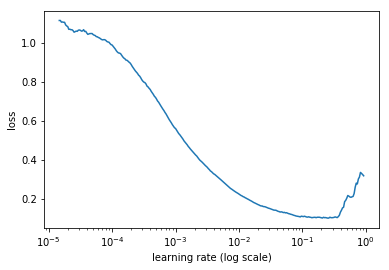

In [46]:
learn.sched.plot()

In [9]:
tfms = tfms_from_model(resnet34, sz, aug_tfms = transforms_side_on, max_zoom = 1.1)

In [10]:
def get_augs():
    data = ImageClassifierData.from_paths(PATH, bs=2, tfms=tfms, num_workers=1)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

In [54]:
ims = np.stack([get_augs() for i in range(6)])

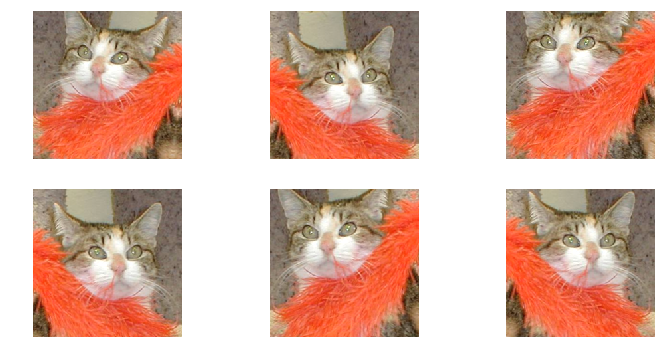

In [55]:
plots(ims, rows = 2)

In [11]:
data = ImageClassifierData.from_paths(PATH, tfms = tfms)
learn = ConvLearner.pretrained(arch, data, precompute = True)

NameError: name 'arch' is not defined

In [57]:
learn.fit(1.0e-2, 1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

[ 0.       0.05109  0.02776  0.99072]                         



In [59]:
learn.precomute = False

In [60]:
learn.fit(1e-2, 3, cycle_len = 1)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

[ 0.       0.04038  0.02714  0.99121]                         
[ 1.       0.03485  0.02654  0.99268]                         
[ 2.       0.04102  0.02625  0.99268]                         



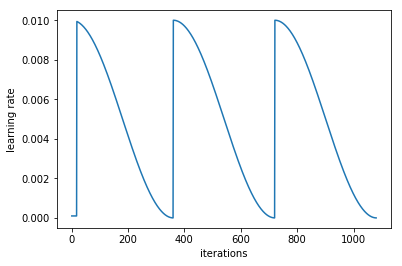

In [62]:
learn.sched.plot_lr()

In [64]:
learn.save("224_lastlayer")

In [13]:
arch = resnet34

tfms = tfms_from_model(resnet34, sz, aug_tfms = transforms_side_on, max_zoom = 1.1)
data = ImageClassifierData.from_paths(PATH, tfms = tfms)
learn = ConvLearner.pretrained(arch, data, precompute = True)

learn.load("224_lastlayer")

In [14]:
learn.model

Sequential(
  (0): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True)
  (1): Dropout(p=0.25)
  (2): Linear(in_features=1024, out_features=512)
  (3): ReLU()
  (4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True)
  (5): Dropout(p=0.5)
  (6): Linear(in_features=512, out_features=2)
  (7): LogSoftmax()
)

In [18]:
learn.unfreeze()

In [22]:
lr = np.array([1e-4, 1e-3, 1e-2])

In [36]:
learn.fit(lr, 3, cycle_len = 1, cycle_mult = 2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

[ 0.       0.0358   0.02774  0.9917 ]                         
[ 1.       0.0393   0.02932  0.98975]                         
[ 2.       0.03263  0.02963  0.99072]                         
[ 3.       0.03797  0.02371  0.99072]                         
[ 4.       0.04784  0.02437  0.99121]                         
[ 5.       0.0294   0.0245   0.99219]                         
[ 6.       0.03702  0.02486  0.99268]                         



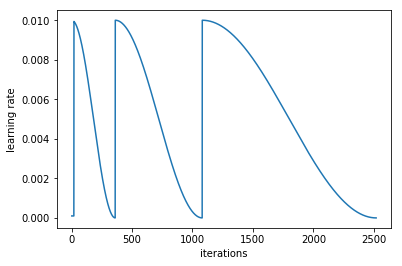

In [37]:
learn.sched.plot_lr()

In [38]:
learn.save("224_all")

In [7]:
arch = resnet34

tfms = tfms_from_model(resnet34, sz, aug_tfms = transforms_side_on, max_zoom = 1.1)
data = ImageClassifierData.from_paths(PATH, tfms = tfms)
learn = ConvLearner.pretrained(arch, data, precompute = True)
learn.unfreeze()

learn.load("224_all")